In [2]:
from os import listdir

In [6]:
depth = 1
height = 160
width = 160

# 2

In [12]:
%%time
from livelossplot import PlotLossesKeras
import numpy as np
import matplotlib.pyplot as plt
import cv2
def load_data_from_folder(images_dir, height, width, depth):
    dir_names = listdir(images_dir)
    dir_count = len(dir_names)
    images_real = {}
    images_forgery = {}
    labels = set()
    for dir_name in dir_names:
        parts = dir_name.split('_')
        label_text = parts[0]
        is_forgery = len(parts) > 1
        if (label_text not in labels):
            labels.add(label_text)
        if label_text not in images_real:
            images_real[label_text] = []
        if label_text not in images_forgery:
            images_forgery[label_text] = []
        image_file_names = listdir(images_dir + '/' + dir_name)
        for image_file_name in image_file_names:
            image = cv2.imread(images_dir + '/' + dir_name + '/' + image_file_name, cv2.IMREAD_GRAYSCALE)
            if is_forgery:
                images_forgery[label_text].append(image)
            else:
                images_real[label_text].append(image)
    X_base_list = []
    X_comparison_list = []
    y_list = []
    for label in labels:
        real_samples = images_real[label]
        forged_samples = images_forgery[label]
        for real_img in real_samples:
            real_resized = cv2.resize(real_img, (width, height))
            for another_real in real_samples:
                another_resized = cv2.resize(another_real,(width, height))
                X_base_list.append(real_resized.reshape((width,height, depth)))               
                X_comparison_list.append(another_resized.reshape((width, height,depth)))
                y_list.append(1)
            for another_fake in forged_samples:
                fake_resized = cv2.resize(another_fake, (width,height))
                X_base_list.append(real_resized.reshape((width,height, depth)))
                X_comparison_list.append(fake_resized.reshape((width, height, depth)))
                y_list.append(0)
    X_base = np.array(X_base_list)
    X_comparison = np.array(X_comparison_list)
    y = np.array(y_list)
    return X_base, X_comparison, y

CPU times: user 77 µs, sys: 0 ns, total: 77 µs
Wall time: 91.6 µs


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Label: 1
(24093, 160, 160, 1)
CPU times: user 3.68 s, sys: 547 ms, total: 4.23 s
Wall time: 4.36 s


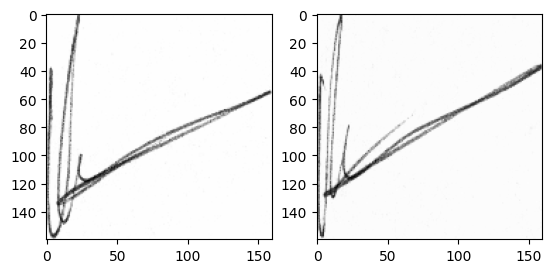

In [32]:
%%time
X_base, X_comparison, y = load_data_from_folder ('sign_data/train', 160,160,1)
index = 3
f, axes = plt.subplots(1,2)
axes[0].imshow(X_base[index, :, :, 0], cmap='gray')
axes[1].imshow(X_comparison[index, :, :, 0], cmap='gray')
print(f'Label: {y[index]}')
print (X_base.shape)

In [33]:
from tensorflow.keras import layers, losses, metrics, optimizers
from tensorflow.keras.models import Model

x1 = layers.Input(shape=(width, height, depth))
x2 = layers.Input(shape=(width, height, depth))
# параллельная модель
inputs = layers.Input(shape=(width, height, depth))
feature = layers.Conv2D(16, 3, activation='relu')(inputs)
feature = layers.MaxPooling2D(2)(feature)
feature = layers.Conv2D(32, 3, activation='relu')(feature)
feature = layers.MaxPooling2D(2)(feature)
feature = layers.Conv2D(64, 3, activation='relu')(feature)
feature = layers.MaxPooling2D(2)(feature)
feature_model = Model(inputs=inputs, outputs=feature)
x1_net = feature_model(x1)
x2_net = feature_model(x2)
net = layers.Subtract()([x1_net, x2_net])
net = layers.Conv2D(64, 3, activation='relu')(net)
net = layers.MaxPooling2D(2)(net)
net = layers.Flatten()(net)
net = layers.Dense(512, activation='relu')(net)
net = layers.Dense(1, activation='sigmoid')(net)
classifier = Model(inputs=[x1, x2], outputs=net)
classifier.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(), metrics=['accuracy'])
classifier.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 18, 18, 64)   23296       ['input_4[0][0]',                
                                                                  'input_5[0][0]']          

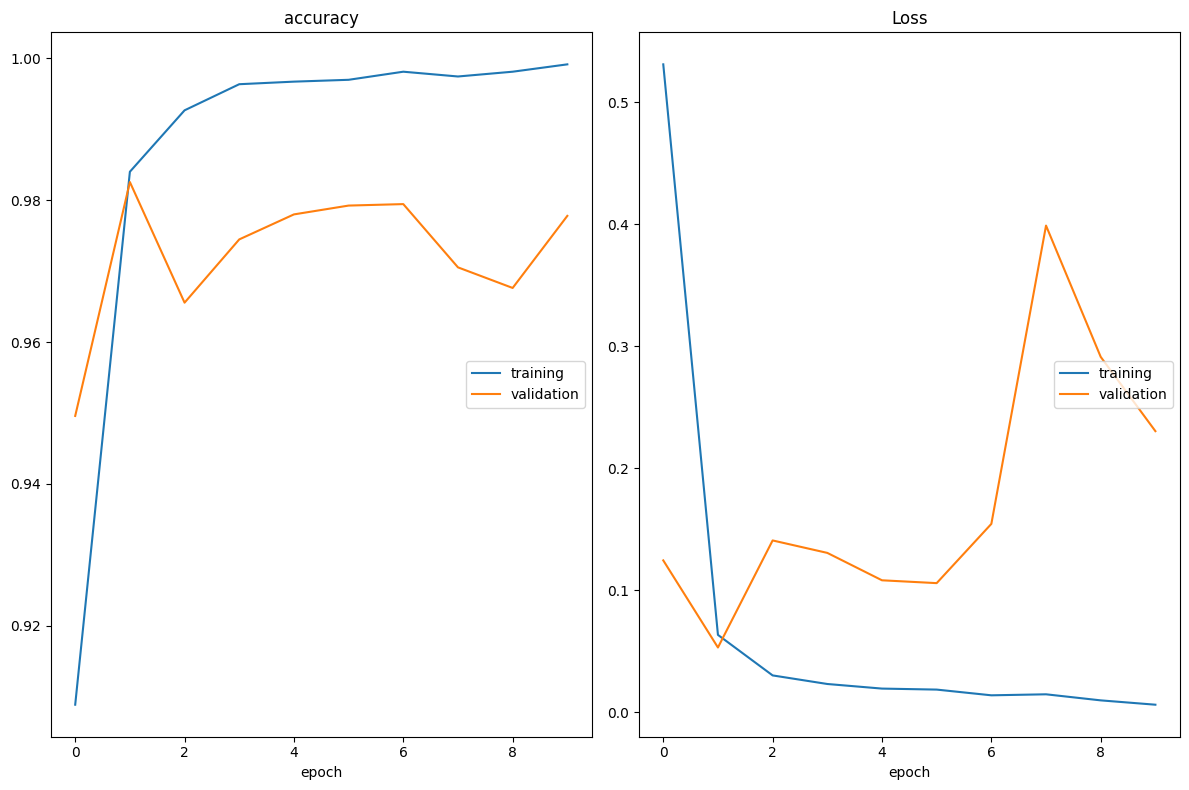

accuracy
	training         	 (min:    0.909, max:    0.999, cur:    0.999)
	validation       	 (min:    0.950, max:    0.983, cur:    0.978)
Loss
	training         	 (min:    0.006, max:    0.531, cur:    0.006)
	validation       	 (min:    0.053, max:    0.399, cur:    0.230)
603/603 [==============================] - 163s 271ms/step - loss: 0.0061 - accuracy: 0.9992 - val_loss: 0.2303 - val_accuracy: 0.9778
CPU times: user 4h 30min 4s, sys: 11min 7s, total: 4h 41min 11s
Wall time: 27min 36s


In [34]:
%%time
classifier.fit([X_base, X_comparison], y,  epochs=10, validation_split=0.2, callbacks=[PlotLossesKeras()])

In [35]:
%%time
X_base_test, X_comparison_test, y_test = load_data_from_folder ('sign_data/test', 160,160,1)
predicts = classifier.predict ([X_base_test,X_comparison_test])
print (predicts)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

188/188 [==============================] - 10s 50ms/step
[[9.9999869e-01]
 [9.9999887e-01]
 [9.9999934e-01]
 ...
 [0.0000000e+00]
 [2.5227452e-35]
 [0.0000000e+00]]
CPU times: user 1min 29s, sys: 4.89 s, total: 1min 34s
Wall time: 11.1 s


In [36]:
predictions_binary = np.zeros (len (predicts))
for i in range (len (predicts)):
    if predicts [i] > 0.30:
        predictions_binary [i] = 1
    else:
        predictions_binary [i] = 0

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
print(confusion_matrix(y_test, predictions_binary))

[[2975    1]
 [   4 3020]]


In [13]:
%%time
X_base_test_my, X_comparison_test_my, y_test_my = load_data_from_folder('sign_data/my_test/111', 160,160,1)

CPU times: user 19.8 ms, sys: 3.7 ms, total: 23.5 ms
Wall time: 23 ms


In [14]:
print(len(X_comparison_test_my))

64


In [15]:
def open_image_test():
    images_dir = 'sign_data/my_test/base'
    images_dir_proba = 'sign_data/my_test/proba'
    file_names = listdir(images_dir)
    file_names_proba = listdir(images_dir_proba)
    width = 160
    height= 160
    depth = 1
    X_base_test_my = np.zeros((len(file_names)*len(file_names_proba), width, height, depth))
    X_comparison_test_my = np.zeros((len(file_names)*len(file_names_proba), width, height, depth))
    index = 0
    for g,file_name in enumerate(file_names):
        full_path = images_dir + '/' + file_name
        image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (160, 160))
        for i in range (len (file_names_proba)):
            X_base_test_my[index] = np.reshape(image, (160, 160, 1))
            index = index + 1

    index = 0
    for g,file_name in enumerate(file_names_proba):
        full_path = images_dir_proba + '/' + file_name
        image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (160, 160))
        for i in range (len (file_names)):
            X_comparison_test_my[index] = np.reshape(image, (160, 160, 1))
            index = index + 1
    return X_base_test_my, X_comparison_test_my

In [16]:
X_base_test_my, X_comparison_test_my = open_image_test()
print (X_comparison_test_my.shape)

(6, 160, 160, 1)


In [17]:
%%time
predict_my_test = classifier.predict ([X_base_test_my, X_comparison_test_my])

NameError: name 'classifier' is not defined

In [88]:
print (predict_my_test)

[[1.2015157e-12]
 [5.8449819e-29]
 [5.2742824e-02]
 [1.0000000e+00]
 [3.3060436e-28]
 [5.8449819e-29]]


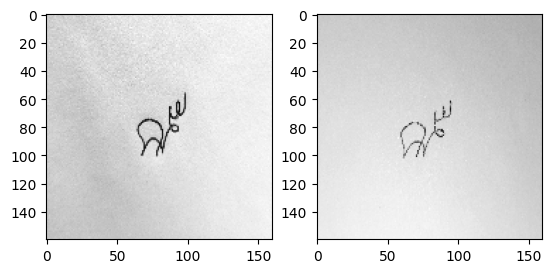

In [89]:
f, axes = plt.subplots(1,2)
axes[0].imshow(X_base_test_my[5], cmap='gray')
axes[1].imshow(X_comparison_test_my[5], cmap='gray')

1/1 [==============================] - 0s 21ms/step
[[1.2015157e-12]
 [5.8449819e-29]
 [5.2742824e-02]
 [1.0000000e+00]
 [3.3060436e-28]
 [5.8449819e-29]]


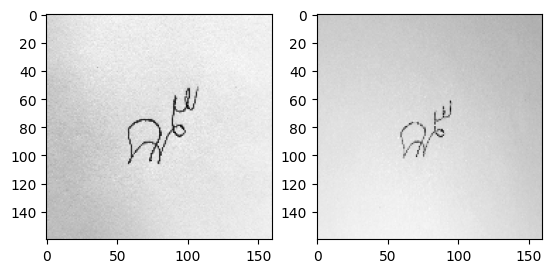

In [90]:
X_base_test_my, X_comparison_test_my = open_image_test()
predict_my_test = classifier.predict ([X_base_test_my, X_comparison_test_my])
print (predict_my_test)
f, axes = plt.subplots(1,2)
axes[0].imshow(X_base_test_my[0], cmap='gray')
axes[1].imshow(X_comparison_test_my[0], cmap='gray')

1/1 [==============================] - 0s 33ms/step
[[1.2015157e-12]
 [5.8449819e-29]
 [5.2742824e-02]
 [1.0000000e+00]
 [3.3060436e-28]
 [5.8449819e-29]]


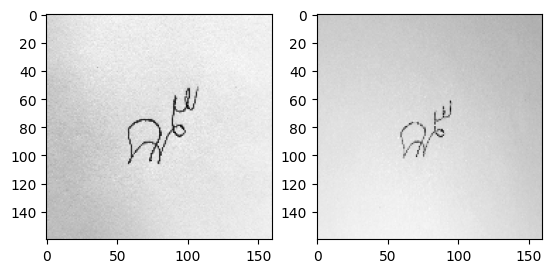

In [93]:
X_base_test_my, X_comparison_test_my = open_image_test()
predict_my_test = classifier.predict ([X_base_test_my, X_comparison_test_my])
print (predict_my_test)
f, axes = plt.subplots(1,2)
axes[0].imshow(X_base_test_my[0], cmap='gray')
axes[1].imshow(X_comparison_test_my[0], cmap='gray')

1/1 [==============================] - 0s 22ms/step
[[1.2015157e-12]
 [5.8449819e-29]
 [5.2742824e-02]
 [1.0000000e+00]
 [3.3060436e-28]
 [5.8449819e-29]]


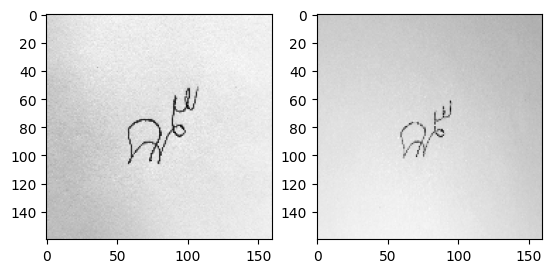

In [94]:
X_base_test_my, X_comparison_test_my = open_image_test()
predict_my_test = classifier.predict ([X_base_test_my, X_comparison_test_my])
print (predict_my_test)
f, axes = plt.subplots(1,2)
axes[0].imshow(X_base_test_my[0], cmap='gray')
axes[1].imshow(X_comparison_test_my[0], cmap='gray')

1/1 [==============================] - 0s 22ms/step
[[1.2015157e-12]
 [5.8449819e-29]
 [5.2742824e-02]
 [1.0000000e+00]
 [3.3060436e-28]
 [5.8449819e-29]]


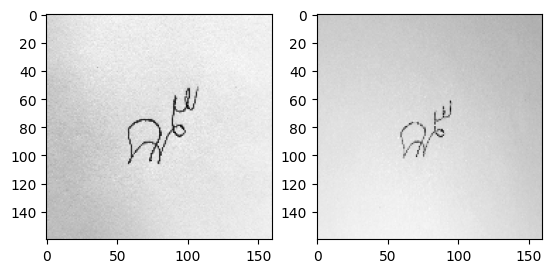

In [95]:
X_base_test_my, X_comparison_test_my = open_image_test()
predict_my_test = classifier.predict ([X_base_test_my, X_comparison_test_my])
print (predict_my_test)
f, axes = plt.subplots(1,2)
axes[0].imshow(X_base_test_my[0], cmap='gray')
axes[1].imshow(X_comparison_test_my[0], cmap='gray')

1/1 [==============================] - 0s 22ms/step
[[1.2015157e-12]
 [5.8449819e-29]
 [5.2742824e-02]
 [1.0000000e+00]
 [3.3060436e-28]
 [5.8449819e-29]]


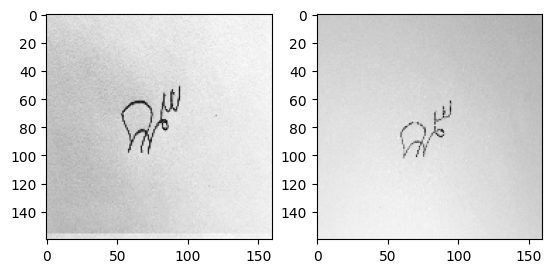

In [82]:
X_base_test_my, X_comparison_test_my = open_image_test()
predict_my_test = classifier.predict ([X_base_test_my, X_comparison_test_my])
print (predict_my_test)
f, axes = plt.subplots(1,2)
axes[0].imshow(X_base_test_my[2], cmap='gray')
axes[1].imshow(X_comparison_test_my[0], cmap='gray')